In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import plot_images
from datasets import load_nist_data

## Perturbed MNIST 

We first define the reference sample as binarized MNIST (with binarization threshold of 0.5)

We now define the following perturbations of peppered MNIST:
- Pepper MNIST with binarizing thresholds different than 0.5 
- Gaussian noise 
- Gaussian Blurr
- Swirl deformation

We will later compute the FID between these datasets and the reference Pepper MNIST (binerized threshold=0.5) 

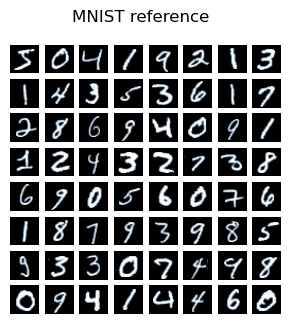

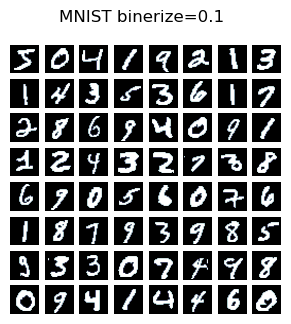

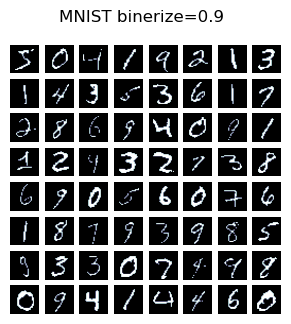

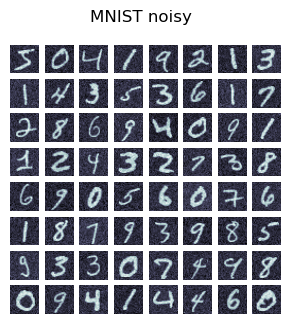

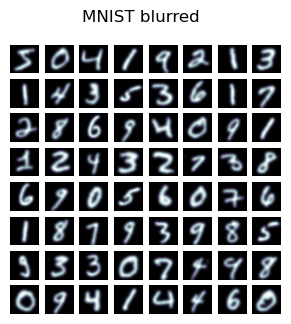

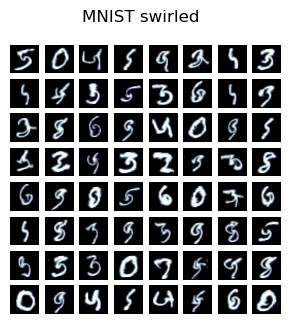

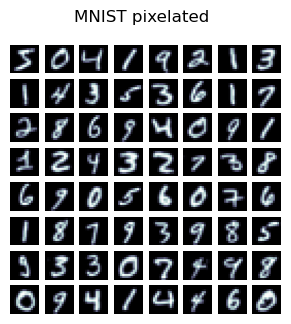

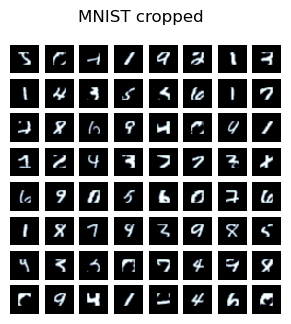

In [2]:
cmap='bone'

#...Reference dfataset:

data = load_nist_data(name='MNIST')
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST reference", figsize=(3.5, 3.5), cmap=cmap)

#...Distorted datasets:

data = load_nist_data(name='MNIST', distortion='binerize', level=0.1)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST binerize=0.1", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='binerize', level=0.9)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST binerize=0.9", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='noise', level=0.1)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST noisy", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='blur', level=1.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST blurred", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='swirl', level=3)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST swirled", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='pixelize', level=0.5)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST pixelated", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='MNIST', distortion='crop', level=0.55)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "MNIST cropped", figsize=(3.5, 3.5), cmap=cmap)


## Perturbed Binary MNIST 

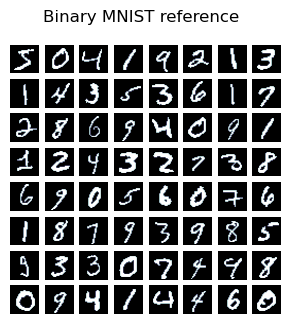

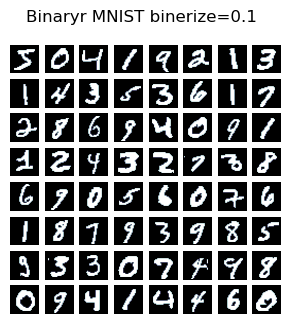

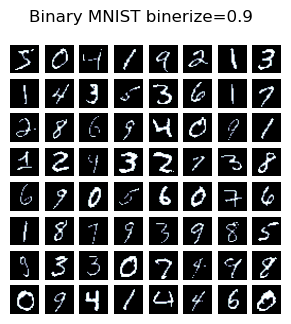

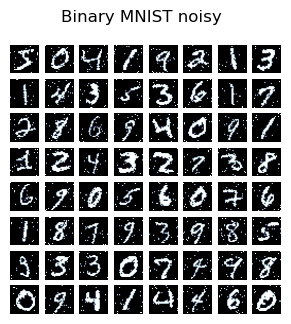

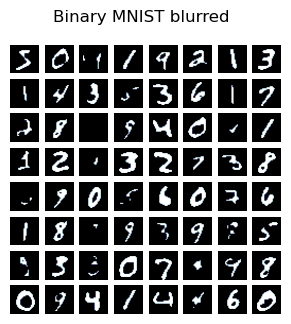

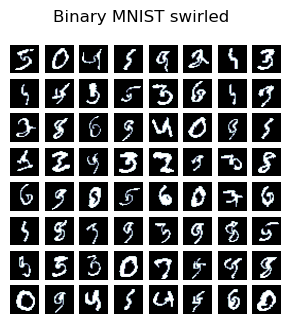

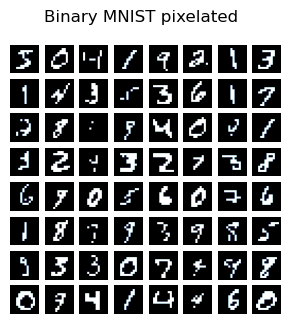

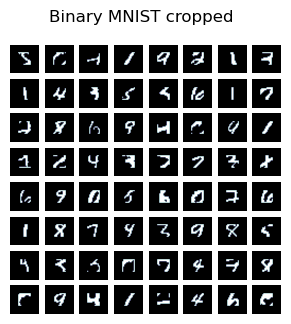

In [3]:
#...Reference dfataset:

data = load_nist_data(name='BinaryMNIST')
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST reference", figsize=(3.5, 3.5), cmap=cmap)

#...Distorted datasets:

data = load_nist_data(name='BinaryMNIST', distortion='binerize', level=0.1)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binaryr MNIST binerize=0.1", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='binerize', level=0.9)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST binerize=0.9", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='noise', level=0.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST noisy", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='blur', level=1.25)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST blurred", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='swirl', level=3)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST swirled", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='pixelize', level=0.5)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST pixelated", figsize=(3.5, 3.5), cmap=cmap)

data = load_nist_data(name='BinaryMNIST', distortion='crop', level=0.55)
dataloader = DataLoader(data, batch_size=64, shuffle=False)
images, _ = next(iter(dataloader))
plot_images(images, "Binary MNIST cropped", figsize=(3.5, 3.5), cmap=cmap)

##  LeNet-5 classifier for MNIST & Binary-MNIST
We load two pre-trained LeNet-5 classifiers and evaluate them on the Reference MNIST datasets to extract the mean and std of the features of intermediate layers. We look into two cases: 1) The standard MNIST dataset and 2) the "Pepper" or binarized MNIST dataset.

The trained LeNet-5 classifiers have classification accuracies above 98%.

1) MNIST classifier

In [2]:
import torch
from architectures import LeNet5
from fid import get_layer_features

model = LeNet5()
model.load_state_dict(torch.load('models/LeNet5_MNIST.pth'))
model.eval()

#...Load MNIST test dataset

test_ref = load_nist_data(name='MNIST', train=False)

#...compute mean and std of features from reference data for each layer:

mu_1, sigma_1 = get_layer_features(model, test_ref, layer='fc1')
mu_2, sigma_2 = get_layer_features(model, test_ref, layer='fc2')
mu_3, sigma_3 = get_layer_features(model, test_ref, layer='fc3')

In [5]:
from fid import compute_fid

data = load_nist_data(name='MNIST',  train=False, distortion='binerize', level=0.5)
fid_1 = compute_fid(model, data, mu_1, sigma_1, layer='fc1')
fid_2 = compute_fid(model, data, mu_2, sigma_2, layer='fc2')
fid_3 = compute_fid(model, data, mu_3, sigma_3, layer='fc3')

print('binerize: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='MNIST', train=False, distortion='noise', level=0.25)
fid_1 = compute_fid(model, data, mu_1, sigma_1, layer='fc1')
fid_2 = compute_fid(model, data, mu_2, sigma_2, layer='fc2')
fid_3 = compute_fid(model, data, mu_3, sigma_3, layer='fc3')

print('gaussian noise: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='MNIST', train=False, distortion='blur', level=1.25)
fid_1 = compute_fid(model, data, mu_1, sigma_1, layer='fc1')
fid_2 = compute_fid(model, data, mu_2, sigma_2, layer='fc2')
fid_3 = compute_fid(model, data, mu_3, sigma_3, layer='fc3')

print('gaussian blur: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='MNIST', train=False, distortion='swirl', level=3)
fid_1 = compute_fid(model, data, mu_1, sigma_1, layer='fc1')
fid_2 = compute_fid(model, data, mu_2, sigma_2, layer='fc2')
fid_3 = compute_fid(model, data, mu_3, sigma_3, layer='fc3')

print('swirl: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='MNIST', train=False, distortion='pixelize', level=0.5)
fid_1 = compute_fid(model, data, mu_1, sigma_1, layer='fc1')
fid_2 = compute_fid(model, data, mu_2, sigma_2, layer='fc2')
fid_3 = compute_fid(model, data, mu_3, sigma_3, layer='fc3')

print('pixelize: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='MNIST', train=False, distortion='crop', level=0.55)
fid_1 = compute_fid(model, data, mu_1, sigma_1, layer='fc1')
fid_2 = compute_fid(model, data, mu_2, sigma_2, layer='fc2')
fid_3 = compute_fid(model, data, mu_3, sigma_3, layer='fc3')

print('crop: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

binerize: fid layer 1 = 10.337459564208984, fid layer 1 = 8.919909477233887, fid layer 1 = 2.5171477794647217
gaussian noise: fid layer 1 = 8.950895309448242, fid layer 1 = 7.146161079406738, fid layer 1 = 2.9247756004333496
gaussian blur: fid layer 1 = 266.07330322265625, fid layer 1 = 248.2587890625, fid layer 1 = 80.07660675048828
swirl: fid layer 1 = 147.55172729492188, fid layer 1 = 132.61257934570312, fid layer 1 = 62.51759338378906
pixelize: fid layer 1 = 165.47216796875, fid layer 1 = 156.52117919921875, fid layer 1 = 51.234161376953125
crop: fid layer 1 = 311.77685546875, fid layer 1 = 253.49850463867188, fid layer 1 = 102.8228530883789


2) Binary MNIST classifier

In [3]:
import torch
from architectures import LeNet5
from fid import get_layer_features

model_bin = LeNet5()
model_bin.load_state_dict(torch.load('models/LeNet5_BinaryMNIST.pth'))
model_bin.eval()

#...Load MNIST test dataset

test_ref = load_nist_data(name='BinaryMNIST', train=False)

#...compute mean and std of features from reference data for each layer:

mu_bin_1, sigma_bin_1 = get_layer_features(model_bin, test_ref, layer='fc1')
mu_bin_2, sigma_bin_2 = get_layer_features(model_bin, test_ref, layer='fc2')
mu_bin_3, sigma_bin_3 = get_layer_features(model_bin, test_ref, layer='fc3')

In [8]:
from fid import compute_fid

data = load_nist_data(name='BinaryMNIST', train=False, distortion='binerize', level=0.8)
fid_1 = compute_fid(model_bin, data, mu_bin_1, sigma_bin_1, layer='fc1')
fid_2 = compute_fid(model_bin, data, mu_bin_2, sigma_bin_2, layer='fc2')
fid_3 = compute_fid(model_bin, data, mu_bin_3, sigma_bin_3, layer='fc3')

print('binerize: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='BinaryMNIST', train=False, distortion='noise', level=0.25)
fid_1 = compute_fid(model_bin, data, mu_bin_1, sigma_bin_1, layer='fc1')
fid_2 = compute_fid(model_bin, data, mu_bin_2, sigma_bin_2, layer='fc2')
fid_3 = compute_fid(model_bin, data, mu_bin_3, sigma_bin_3, layer='fc3')

print('gaussian noise: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='BinaryMNIST', train=False, distortion='blur', level=1.25)
fid_1 = compute_fid(model_bin, data, mu_bin_1, sigma_bin_1, layer='fc1')
fid_2 = compute_fid(model_bin, data, mu_bin_2, sigma_bin_2, layer='fc2')
fid_3 = compute_fid(model_bin, data, mu_bin_3, sigma_bin_3, layer='fc3')

print('gaussian blur: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='BinaryMNIST', train=False, distortion='swirl', level=3)
fid_1 = compute_fid(model_bin, data, mu_bin_1, sigma_bin_1, layer='fc1')
fid_2 = compute_fid(model_bin, data, mu_bin_2, sigma_bin_2, layer='fc2')
fid_3 = compute_fid(model_bin, data, mu_bin_3, sigma_bin_3, layer='fc3')

print('swirl: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='BinaryMNIST', train=False, distortion='pixelize', level=0.5)
fid_1 = compute_fid(model_bin, data, mu_bin_1, sigma_bin_1, layer='fc1')
fid_2 = compute_fid(model_bin, data, mu_bin_2, sigma_bin_2, layer='fc2')
fid_3 = compute_fid(model_bin, data, mu_bin_3, sigma_bin_3, layer='fc3')

print('pixelize: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

data = load_nist_data(name='BinaryMNIST', train=False, distortion='crop', level=0.55)
fid_1 = compute_fid(model_bin, data, mu_bin_1, sigma_bin_1, layer='fc1')
fid_2 = compute_fid(model_bin, data, mu_bin_2, sigma_bin_2, layer='fc2')
fid_3 = compute_fid(model_bin, data, mu_bin_3, sigma_bin_3, layer='fc3')

print('crop: fid layer 1 = {}, fid layer 1 = {}, fid layer 1 = {}'.format(fid_1, fid_2, fid_3))

binerize: fid layer 1 = 8.893750190734863, fid layer 1 = 8.288071632385254, fid layer 1 = 2.469705104827881
gaussian noise: fid layer 1 = 20.926010131835938, fid layer 1 = 20.34969711303711, fid layer 1 = 7.551187515258789
gaussian blur: fid layer 1 = 12.896318435668945, fid layer 1 = 10.980520248413086, fid layer 1 = 3.4042322635650635
swirl: fid layer 1 = 117.69087219238281, fid layer 1 = 100.13536834716797, fid layer 1 = 44.53196716308594
pixelize: fid layer 1 = 17.21929931640625, fid layer 1 = 14.805121421813965, fid layer 1 = 5.746057510375977
crop: fid layer 1 = 194.0457763671875, fid layer 1 = 150.25027465820312, fid layer 1 = 64.93789672851562


## FID Experiments

Below we compute the FID metric between the reference MNIST data and various distortion levels.
For the classifier we used the LeNet-5 architecture as above. We show that the FID computed from 
features in the second layer has a better separation power than the featuires extracted from
the first and third layers accross all considered deformation. 

### 1. Binarized

dataset: MNIST



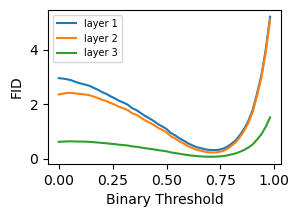

In [6]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1.0, 0.02), layer='fc1')
fid_2 = fid_distorted_NIST(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1.0, 0.02), layer='fc2')
fid_3 = fid_distorted_NIST(model, name='MNIST', distortion='binerize', values=np.arange(0.0, 1.0, 0.02), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Binary Threshold')
plt.legend(loc='upper left', fontsize=7)
plt.show()

Binary MNIST:

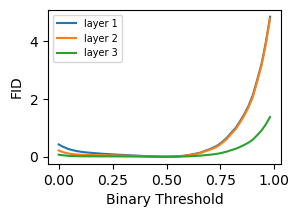

In [7]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='binerize', values=np.arange(0.0, 1.0, 0.02), layer='fc1')
fid_2 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='binerize', values=np.arange(0.0, 1.0, 0.02), layer='fc2')
fid_3 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='binerize', values=np.arange(0.0, 1.0, 0.02), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Binary Threshold')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 2. Gaussian noise

MNIST:

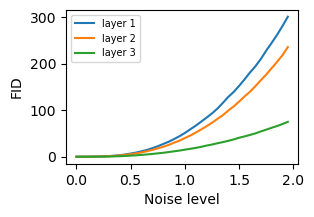

In [8]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc1')
fid_2 = fid_distorted_NIST(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc2')
fid_3 = fid_distorted_NIST(model, name='MNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Noise level')
plt.legend(loc='upper left', fontsize=7)
plt.show()

Binary MNIST:

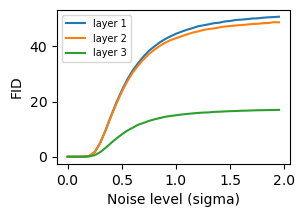

In [9]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc1')
fid_2 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc2')
fid_3 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='noise', values=np.arange(0.0, 2, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Noise level (sigma)')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 3. Gaussian blur

MNIST:

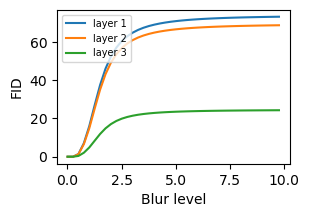

In [10]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc1')
fid_2 = fid_distorted_NIST(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc2')
fid_3 = fid_distorted_NIST(model, name='MNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Blur level')
plt.legend(loc='upper left', fontsize=7)
plt.show()

Binary MNIST:

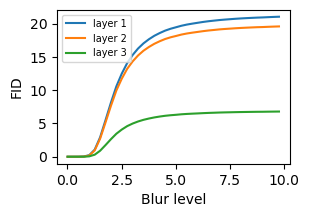

In [11]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc1')
fid_2 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc2')
fid_3 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='blur', values=np.arange(0.01, 10, 0.25), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Blur level')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 4. Swirl deformation

MNIST:

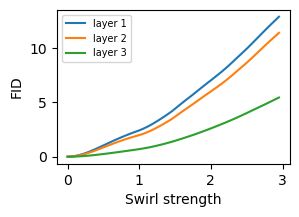

In [12]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc1')
fid_2 = fid_distorted_NIST(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc2')
fid_3 = fid_distorted_NIST(model, name='MNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Swirl strength')
plt.legend(loc='upper left', fontsize=7)
plt.show()

Binary MNIST:

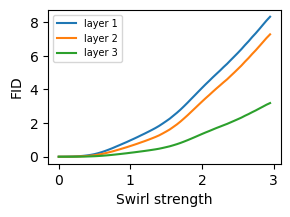

In [13]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc1')
fid_2 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc2')
fid_3 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='swirl', values=np.arange(0, 3, 0.05), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('Swirl strength')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 5. Pixelization

MNIST:

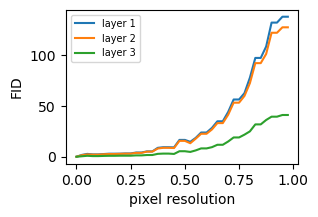

In [14]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc1')
fid_2 = fid_distorted_NIST(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc2')
fid_3 = fid_distorted_NIST(model, name='MNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('pixel resolution')
plt.legend(loc='upper left', fontsize=7)
plt.show()

Binary MNIST:

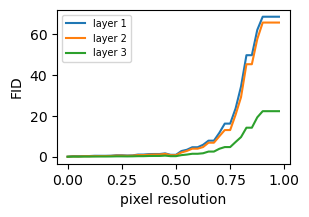

In [15]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc1')
fid_2 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc2')
fid_3 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='pixelize', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('pixel resolution')
plt.legend(loc='upper left', fontsize=7)
plt.show()

### 6. Crop image

MNIST:

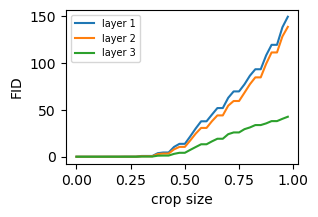

In [16]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc1')
fid_2 = fid_distorted_NIST(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc2')
fid_3 = fid_distorted_NIST(model, name='MNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('crop size')
plt.legend(loc='upper left', fontsize=7)
plt.show()

Binary MNIST:

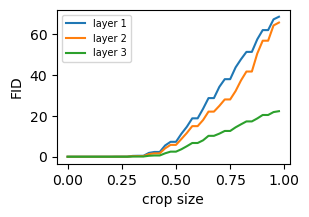

In [17]:
import numpy as np
from fid import fid_distorted_NIST

fid_1 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc1')
fid_2 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc2')
fid_3 = fid_distorted_NIST(model_bin, name='BinaryMNIST', distortion='crop', values=np.arange(0, 1, 0.025), layer='fc3')

fig, ax = plt.subplots(1,1, figsize=(3,2))
plt.plot(fid_1.keys(), fid_1.values(), label='layer 1')
plt.plot(fid_2.keys(), fid_2.values(), label='layer 2')
plt.plot(fid_3.keys(), fid_3.values(), label='layer 3')
plt.ylabel('FID')
plt.xlabel('crop size')
plt.legend(loc='upper left', fontsize=7)
plt.show()